# Experimentación - EvolveGCN

https://arxiv.org/abs/1902.10191

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "EvolveGCN"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from utils.dygrae import DyGrEncoder
from sklearn.metrics import r2_score
from utils.evolvegcn_dynamic import EvolveGCNO
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel, TrainerEvolveGCN
from utils import trainer


In [6]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, name, node_features, node_count, n_target):
        self.name  =name
        self.n_nodes = node_count
        self.n_target = n_target
        self.n_features = node_features
        super(RecurrentGCN, self).__init__()
        self.recurrent = EvolveGCNO(self.n_features)
        self.linear = torch.nn.Linear(self.n_features, n_target)


    def forward(self, x, edge_index, edge_weight):
       
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        
        return h

## Prueba - predicción por tipos

In [11]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}


num_early_stop = 15
num_epochs = 100
lr = 0.01

### Gen trip

In [12]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)

 

Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [13]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5

device = torch.device('cpu' if torch.backends.mps.is_available() else 'cpu')


#### Sencilla 


==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 5.4270 | Eval Loss: 0.8631 | Eval R2: -422.8997 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.7855 | Eval Loss: 0.7441 | Eval R2: -359.8654 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.6853 | Eval Loss: 0.6491 | Eval R2: -311.1546 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.5947 | Eval Loss: 0.5602 | Eval R2: -265.3886 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.5161 | Eval Loss: 0.4855 | Eval R2: -227.3372 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.4379 | Eval Loss: 0.4142 | Eval R2: -189.9142 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.3768 | Eval Loss: 0.3548 | Eval R2: -159.3202 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.3278 | Eval Loss: 0.3057 | Eval R2: -134.3694 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.2849 | Eval Loss: 0.2646 | Eval R2: -113.6272 | LR: 0.0010 | 
Epoch 10/100 | Tra

ValueError: All arrays must be of the same length

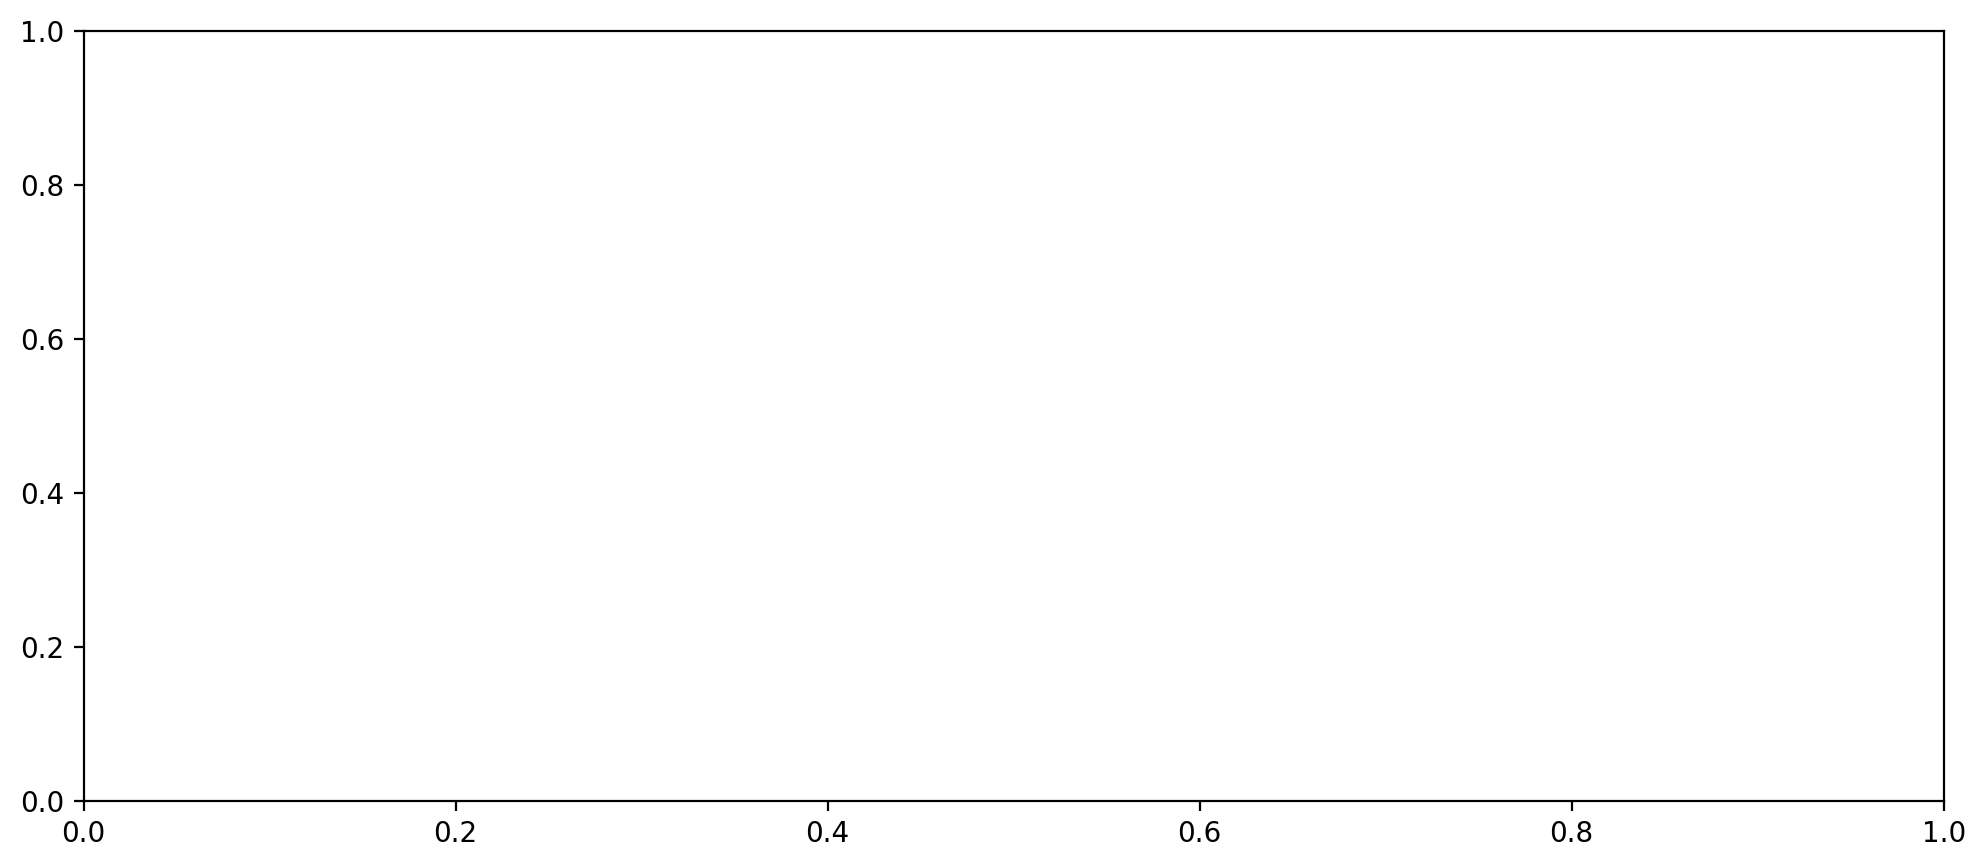

In [14]:

model = RecurrentGCN("EvolveGCN",node_features= n_features, node_count=n_nodes, n_target=n_target)


trainer_gt = TrainerEvolveGCN(model, dataset_gt, device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores = trainer_gt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)




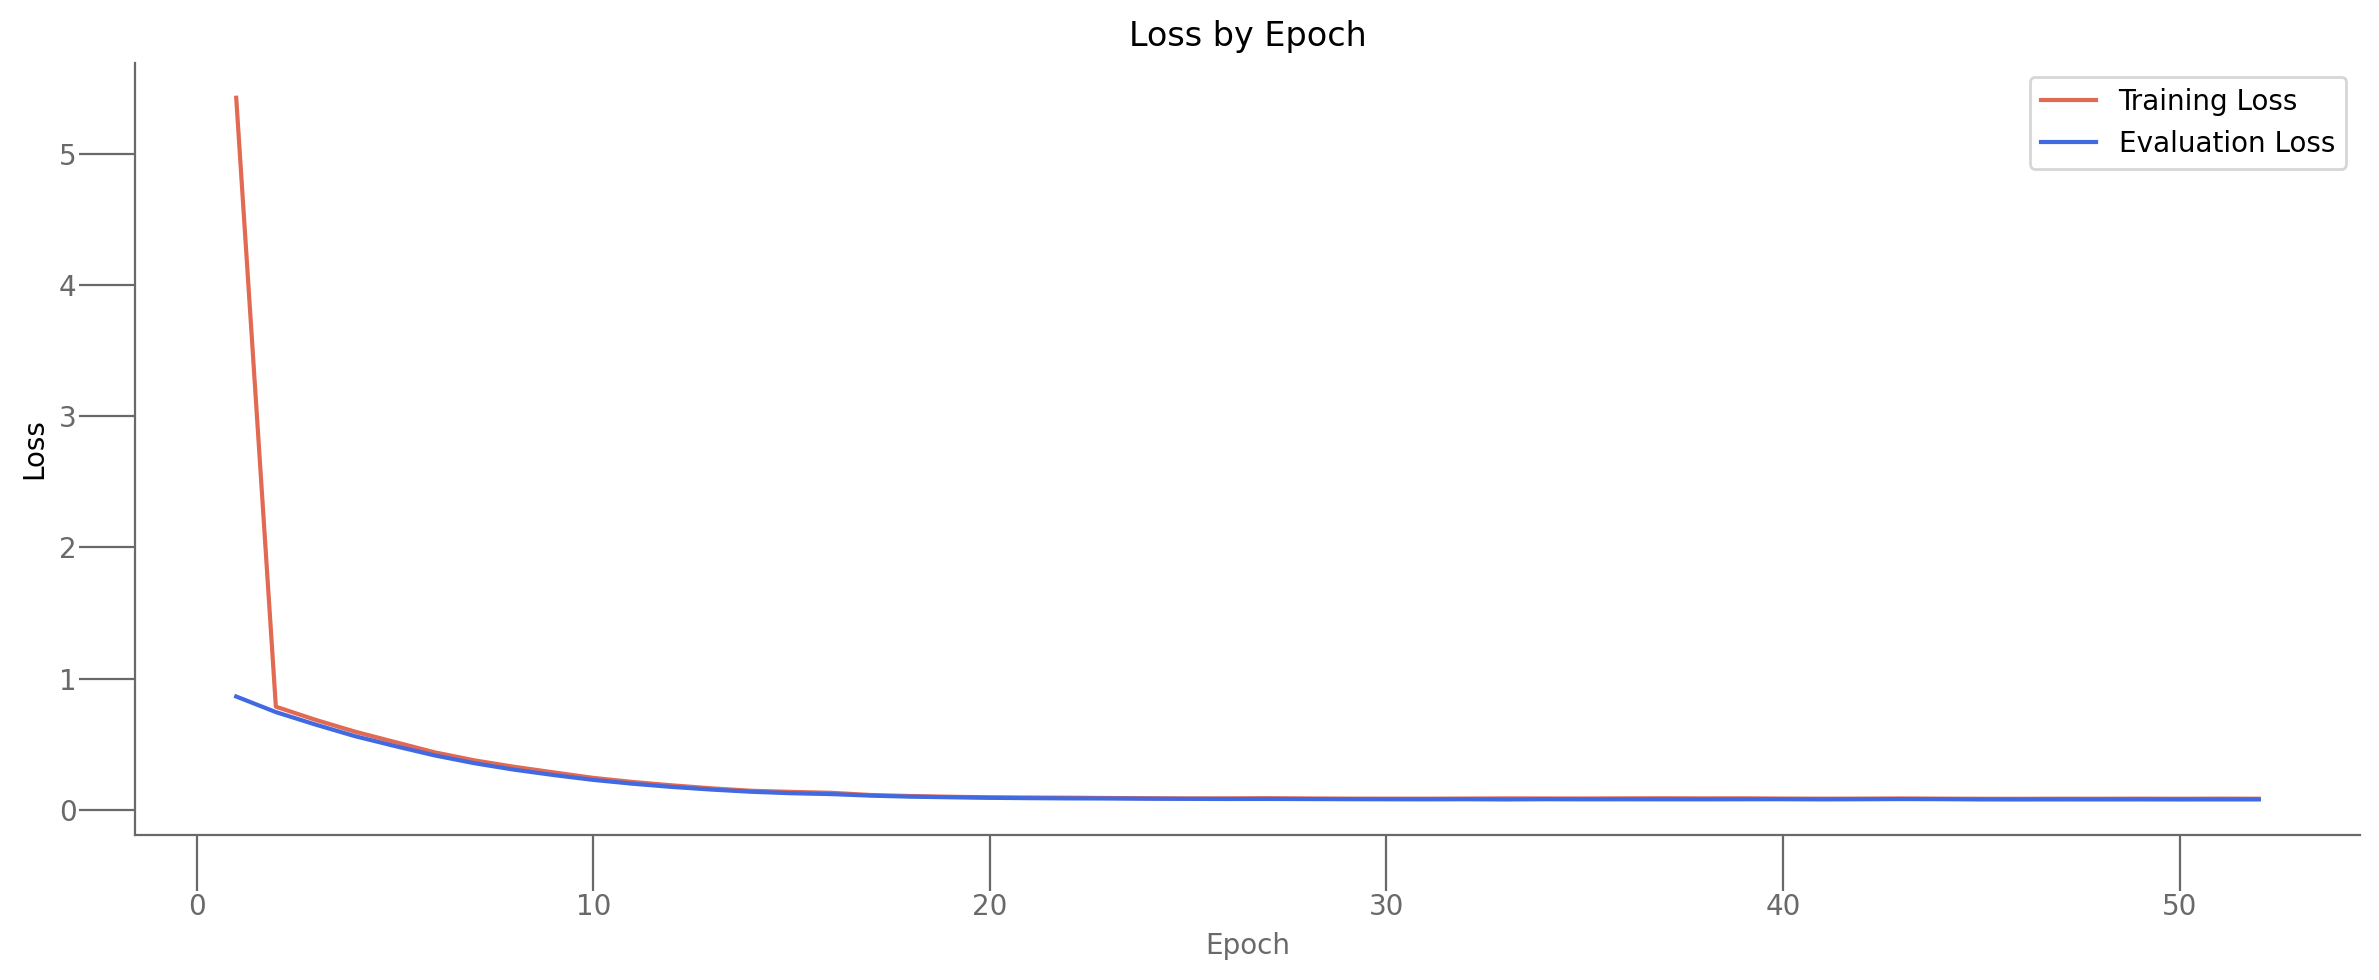


==================== TEST INFO ===================



RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [17]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), len(losses), format_plot)
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()

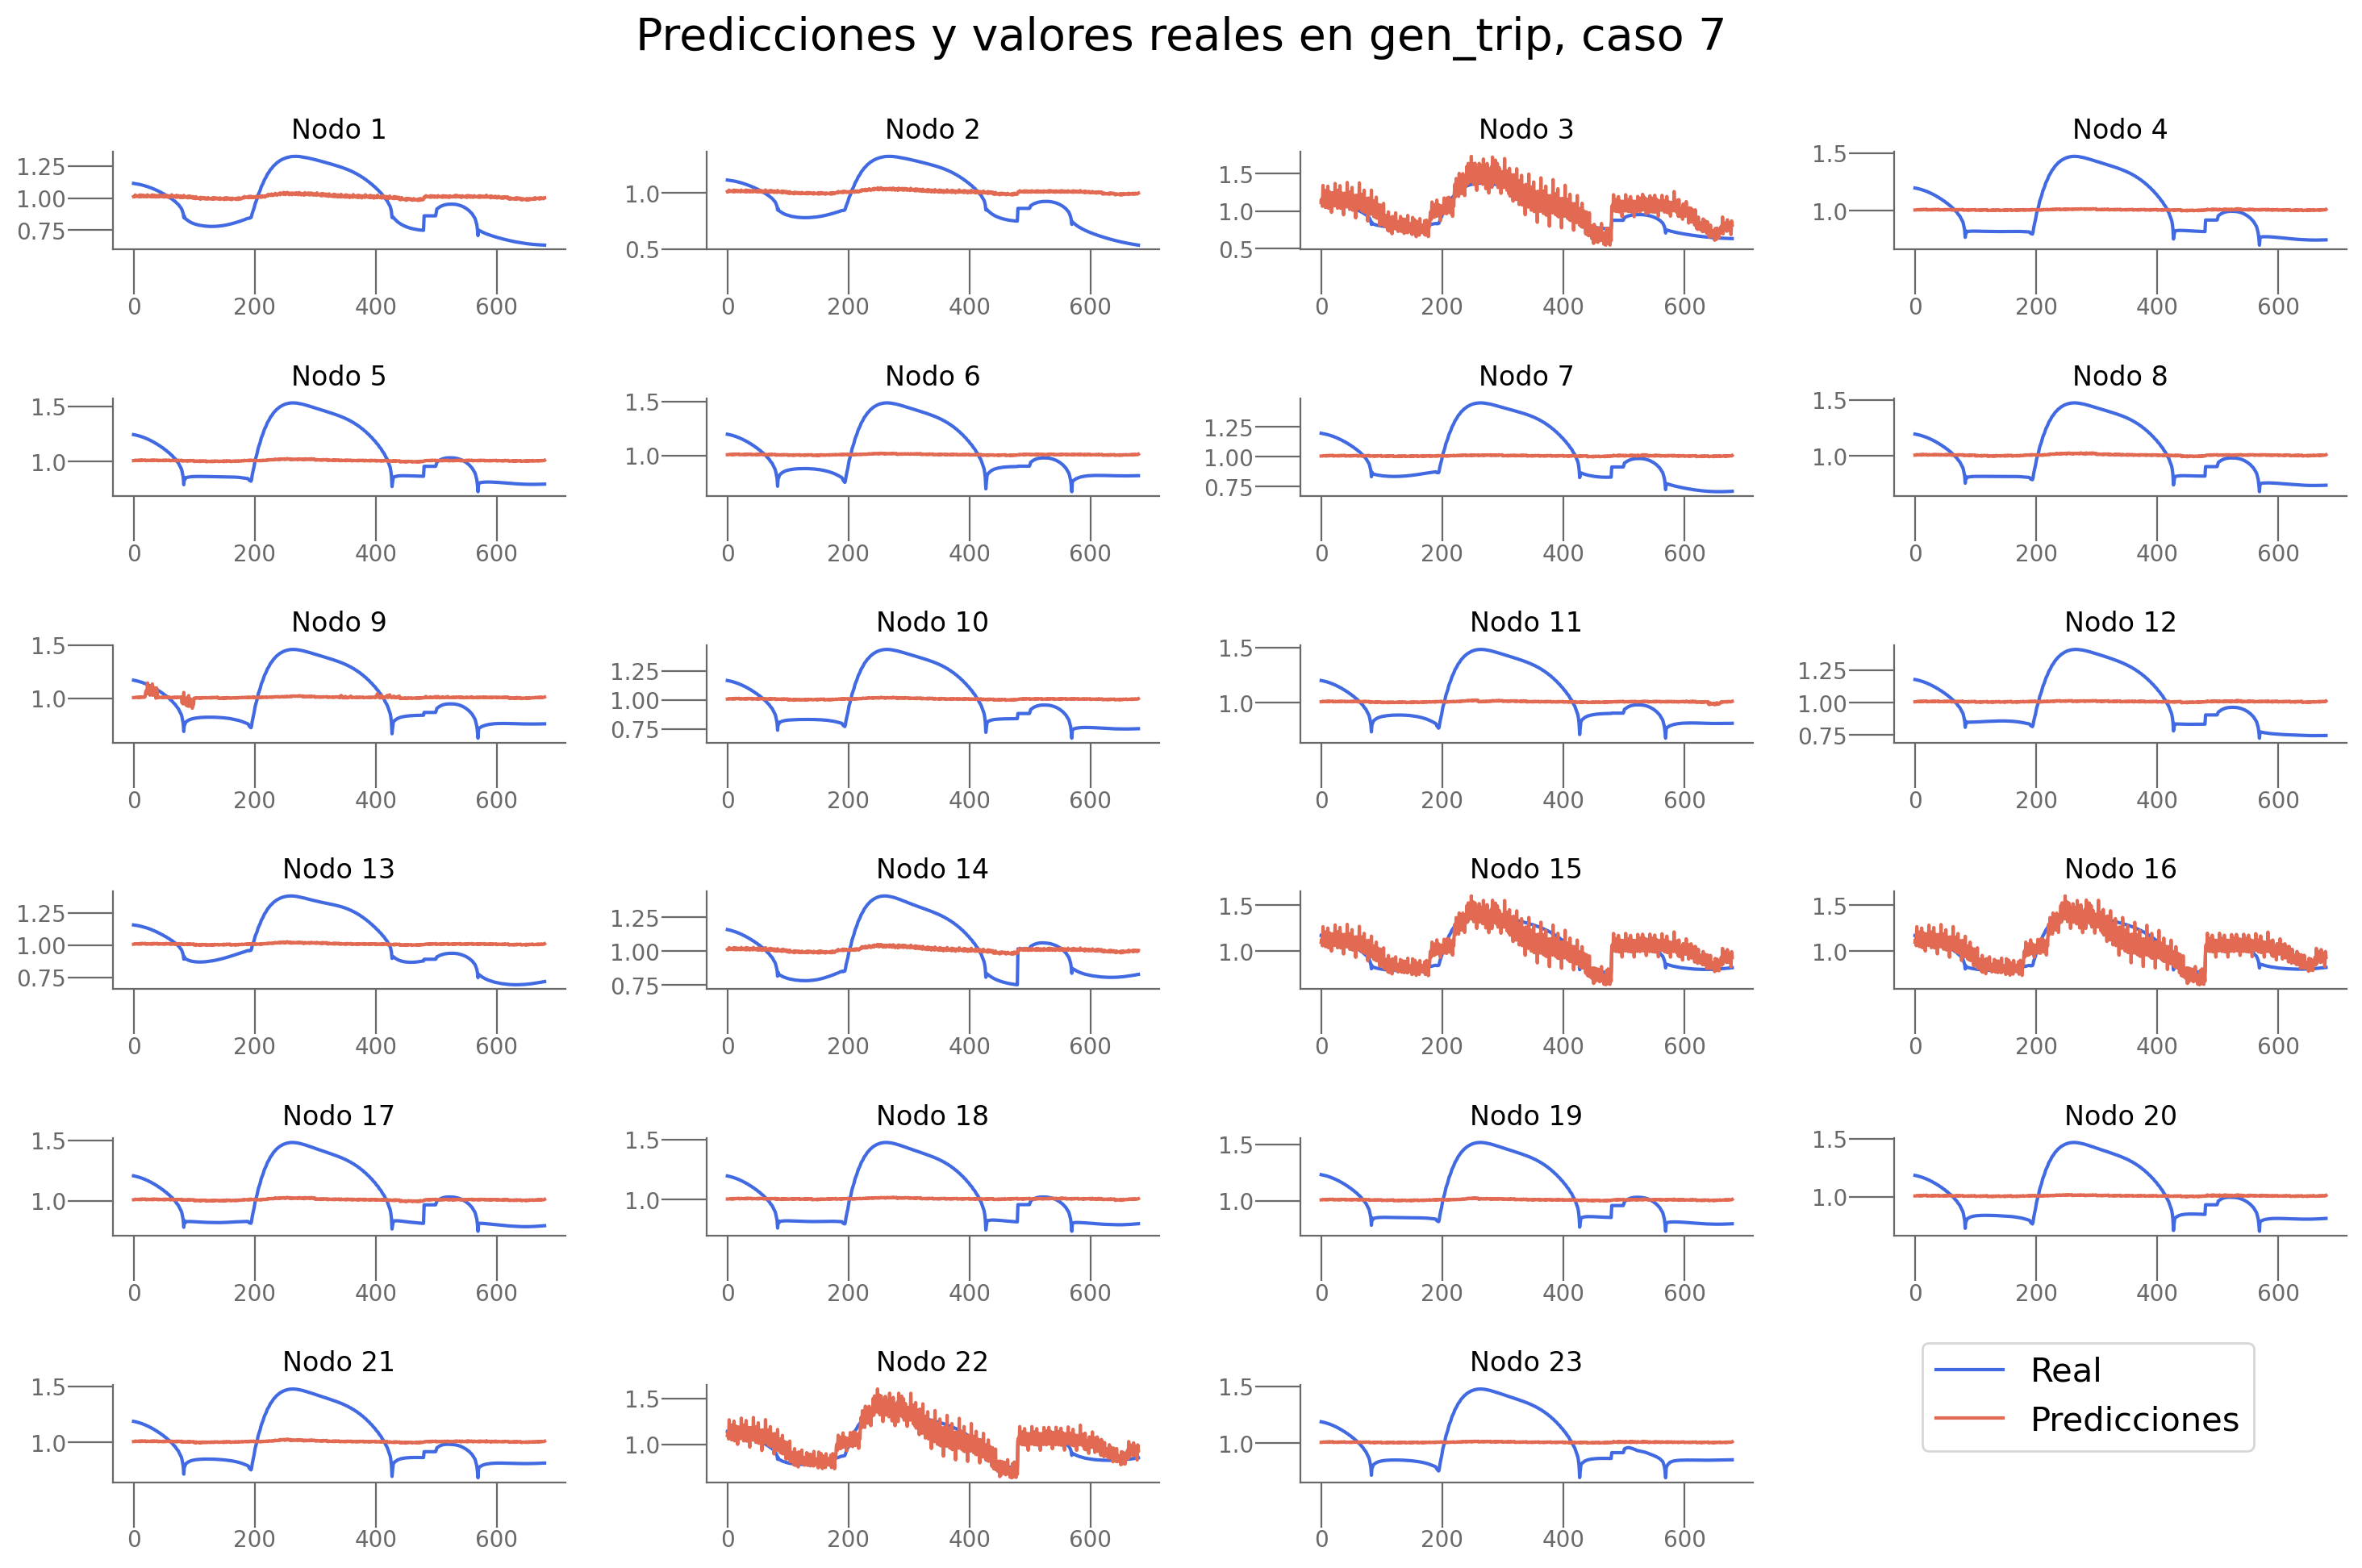

In [ ]:
plot_predictions(predictions, real, n_target, 7, n_div_gt, problem_gt)

#### Ajuste de parámetros

In [ ]:
param_grid = {
    "aggr": ["add", "mean"],
    "conv": [1,2],
    "lstm": [1,2]
}

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

In [ ]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [ ]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [ ]:
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [ ]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)